In [ ]:
# Install required packages
!pip install kagglehub opencv-python-headless gradio

# Import libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub
import cv2
import time
from threading import Thread
from queue import Queue
import gradio as gr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
# Configure parameters
DATASET_NAME = "omkar453/disaster-images-for-ml"
BASE_DIR = "/content/disaster_classification"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
SEED = 42
CLASS_NAMES = ["Disaster", "Non_Damage"]

# Download and extract dataset
print("Downloading dataset...")
dataset_path = kagglehub.dataset_download(DATASET_NAME)
print(f"Dataset downloaded to: {dataset_path}")


100%|██████████| 816M/816M [00:37<00:00, 23.0MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/omkar453/disaster-images-for-ml/versions/1


In [ ]:
# Setup directory structure
print("\nCreating directory structure...")
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

os.makedirs(os.path.join(BASE_DIR, "train", "Disaster"))
os.makedirs(os.path.join(BASE_DIR, "train", "Non_Damage"))
os.makedirs(os.path.join(BASE_DIR, "val", "Disaster"))
os.makedirs(os.path.join(BASE_DIR, "val", "Non_Damage"))
os.makedirs(os.path.join(BASE_DIR, "test", "Disaster"))
os.makedirs(os.path.join(BASE_DIR, "test", "Non_Damage"))



Creating directory structure...


In [ ]:
# Process images
print("\nProcessing images...")
main_dir = os.path.join(dataset_path, "Comprehensive Disaster Dataset(CDD)")

for category in CLASS_NAMES:
    print(f"\nProcessing {category} images...")
    category_dir = os.path.join(main_dir, category)

    # Collect all image paths
    image_paths = []
    for root, _, files in os.walk(category_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    # Split dataset (70-15-15)
    train_files, test_files = train_test_split(image_paths, test_size=0.3, random_state=SEED)
    val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=SEED)

    # Copy files with preprocessing
    for split_name, split_files in [("train", train_files), ("val", val_files), ("test", test_files)]:
        dest_dir = os.path.join(BASE_DIR, split_name, category)
        print(f"\nCopying {split_name} files to {dest_dir}")

        for src_path in tqdm(split_files):
            try:
                img = cv2.imread(src_path)
                if img is None:
                    continue

                # Preprocessing
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMAGE_SIZE)
                dst_path = os.path.join(dest_dir, os.path.basename(src_path))
                cv2.imwrite(dst_path, img)

            except Exception as e:
                print(f"Skipped {src_path}: {str(e)}")




Processing images...

Processing Disaster images...

Copying train files to /content/disaster_classification/train/Disaster


100%|██████████| 7370/7370 [00:44<00:00, 166.36it/s]



Copying val files to /content/disaster_classification/val/Disaster


100%|██████████| 1579/1579 [00:08<00:00, 183.20it/s]



Copying test files to /content/disaster_classification/test/Disaster


100%|██████████| 1580/1580 [00:08<00:00, 187.66it/s]



Processing Non_Damage images...

Copying train files to /content/disaster_classification/train/Non_Damage


100%|██████████| 7044/7044 [00:26<00:00, 267.55it/s]



Copying val files to /content/disaster_classification/val/Non_Damage


100%|██████████| 1510/1510 [00:05<00:00, 266.06it/s]



Copying test files to /content/disaster_classification/test/Non_Damage


100%|██████████| 1510/1510 [00:05<00:00, 292.13it/s]


In [ ]:
# Create enhanced data generators
print("\nCreating data generators...")
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='reflect'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "train"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_gen = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "val"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(BASE_DIR, "test"),
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)




Creating data generators...
Found 14414 images belonging to 2 classes.
Found 3088 images belonging to 2 classes.
Found 3090 images belonging to 2 classes.


In [ ]:
# Custom F1Score metric
class CustomF1Score(tf.keras.metrics.F1Score):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.expand_dims(y_true, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# Build enhanced model
def build_enhanced_model():
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE + (3,)
    )
    base_model.trainable = True

    model = models.Sequential([
        layers.RandomRotation(0.1),
        layers.RandomContrast(0.1),
        layers.RandomZoom(0.1),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.6),
        layers.Dense(256, activation='relu', kernel_regularizer='l2'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    # Class weighting
    total = len(train_gen.classes)
    disaster_count = np.sum(train_gen.classes)
    class_weights = {
        0: (1 / disaster_count) * (total / 2.0),
        1: (1 / (total - disaster_count)) * (total / 2.0)
    }

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='binary_focal_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC', CustomF1Score(name='f1_score', threshold=0.5)]
    )
    return model, class_weights

model, class_weights = build_enhanced_model()



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Training configuration
callbacks = [
    ModelCheckpoint("best_model.keras",
                  monitor='val_f1_score',
                  mode='max',
                  save_best_only=True),
    EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

# Train model
print("\nTraining model...")
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights
)




Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 322s 605ms/step - AUC: 0.5279 - Precision: 0.5138 - Recall: 0.5103 - accuracy: 0.5206 - f1_score: 0.5120 - loss: 4.8885 - val_AUC: 0.7311 - val_Precision: 0.5898 - val_Recall: 0.8636 - val_accuracy: 0.6396 - val_f1_score: 0.7009 - val_loss: 4.3526 - learning_rate: 1.0000e-05
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 268s 593ms/step - AUC: 0.6792 - Precision: 0.6180 - Recall: 0.6264 - accuracy: 0.6253 - f1_score: 0.6222 - loss: 4.5687 - val_AUC: 0.8429 - val_Precision: 0.7646 - val_Recall: 0.7444 - val_accuracy: 0.7630 - val_f1_score: 0.7544 - val_loss: 4.1605 - learning_rate: 1.0000e-05
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 323s 595ms/step - AUC: 0.7646 - Precision: 0.6859 - Recall: 0.6883 - accuracy: 0.6948 - f1_score: 0.6870 - loss: 4.3571 - val_AUC: 0.9176 - val_Precision: 0.8399 - val_Recall: 0.8199 - val_accuracy: 0.8355 - val_f1_score: 0.8298 - val_loss: 3.9993 - learning_rate: 1.0000e-05
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 268s 595ms/s

In [ ]:
# Threshold optimization
print("\nOptimizing classification threshold...")
val_probs = model.predict(val_gen)
val_labels = val_gen.classes
thresholds = np.linspace(0.2, 0.8, 50)
best_threshold = thresholds[np.argmax([f1_score(val_labels, (val_probs > t).astype(int)) for t in thresholds])]
print(f"Optimal threshold: {best_threshold:.2f}")


Optimizing classification threshold...
97/97 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step
Optimal threshold: 0.33



Final Evaluation:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step

Classification Report:
              precision    recall  f1-score   support

    Disaster       0.94      0.89      0.91      1580
  Non_Damage       0.89      0.94      0.91      1510

    accuracy                           0.91      3090
   macro avg       0.91      0.91      0.91      3090
weighted avg       0.92      0.91      0.91      3090


Classification Report:
              precision    recall  f1-score   support

    Disaster       0.94      0.89      0.91      1580
  Non_Damage       0.89      0.94      0.91      1510

    accuracy                           0.91      3090
   macro avg       0.91      0.91      0.91      3090
weighted avg       0.92      0.91      0.91      3090



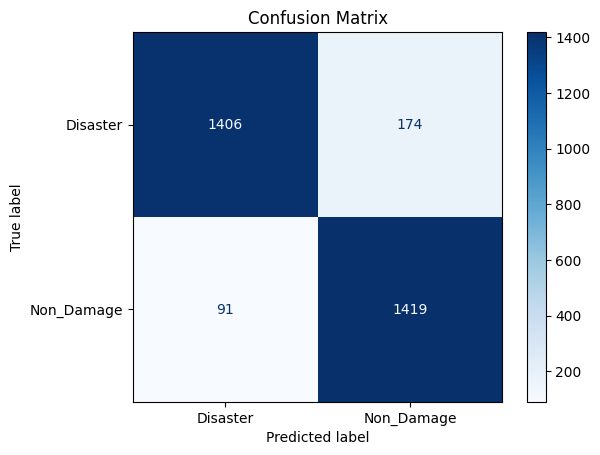

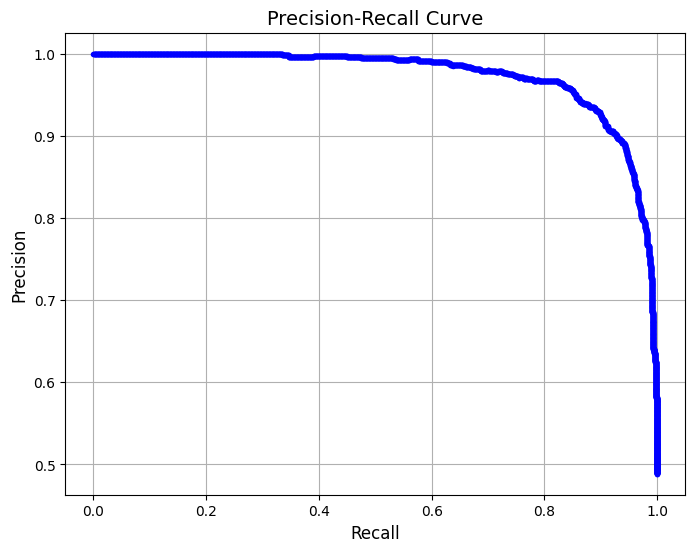

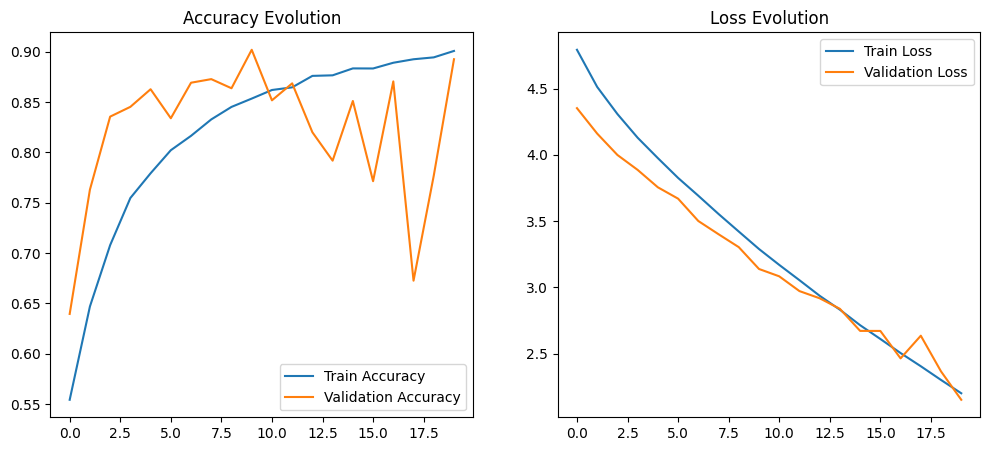


Saving final model...
Model saved as disaster_classifier.keras


In [ ]:
# Final evaluation
print("\nFinal Evaluation:")
best_model = tf.keras.models.load_model("best_model.keras", custom_objects={'CustomF1Score': CustomF1Score})
test_probs = best_model.predict(test_gen)
test_preds = (test_probs > best_threshold).astype(int)

print("\nClassification Report:")
print(classification_report(test_gen.classes, test_preds, target_names=CLASS_NAMES))

# Classification report
print("\nClassification Report:")
print(classification_report(test_gen.classes, test_preds, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(test_gen.classes, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(test_gen.classes, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.grid(True)
plt.show()

# Training history visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.legend()
plt.show()

# Save final model
print("\nSaving final model...")
best_model.save("disaster_classifier.keras")
print("Model saved as disaster_classifier.keras")


In [ ]:
import tensorflow as tf

# Define CustomF1Score before loading the model
@tf.keras.utils.register_keras_serializable()
class CustomF1Score(tf.keras.metrics.F1Score):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.expand_dims(y_true, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

# ... (your model building and training code) ...


# Load the model with the custom_objects argument
best_model = tf.keras.models.load_model("best_model.keras", custom_objects={'CustomF1Score': CustomF1Score, 'f1_score': CustomF1Score})

# ... (rest of your code) ...

In [ ]:
def evaluate_test_classes(model, threshold=0.5):
    """Run separate evaluation loops on disaster and non-disaster test folders,
       printing image paths and predictions."""
    results = {
        'Disaster': {'total': 0, 'correct': 0, 'accuracy': 0, 'avg_confidence': 0},
        'Non_Damage': {'total': 0, 'correct': 0, 'accuracy': 0, 'avg_confidence': 0}
    }

    def process_class(class_name):
        """Process all images in a test class folder"""
        class_dir = os.path.join(BASE_DIR, "test", class_name)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        total = len(images)
        correct = 0
        confidences = []

        for idx, img_name in enumerate(images, 1):
            img_path = os.path.join(class_dir, img_name)

            try:
                # Preprocess image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMAGE_SIZE)
                tensor = img.astype(np.float32) / 255.0

                # Predict
                pred = model.predict(np.expand_dims(tensor, axis=0))[0][0]

                # *** Invert the prediction logic ***
                predicted_class = "Non_Damage" if pred > threshold else "Disaster"
                confidence = 1 - pred if predicted_class == "Disaster" else pred  # Adjust confidence accordingly

                # Update metrics
                is_correct = 1 if predicted_class == class_name else 0
                correct += is_correct
                confidences.append(confidence)

                # Print image path and prediction
                print(f"{img_path}: Predicted - {predicted_class} (Confidence: {confidence:.1%})")

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")

        # Final class metrics
        results[class_name] = {
            'total': total,
            'correct': correct,
            'accuracy': correct / total if total > 0 else 0,
            'avg_confidence': np.mean(confidences) if confidences else 0
        }

    # Process disaster class
    process_class('Disaster')

    # Process non-disaster class
    process_class('Non_Damage')

    # Print results
    print("\nEvaluation Results:")
    for class_name, metrics in results.items():
        print(f"\n{class_name} Class:")
        print(f"  Processed: {metrics['total']}")
        print(f"  Correct: {metrics['correct']}")
        print(f"  Accuracy: {metrics['accuracy']:.1%}")
        print(f"  Avg Confidence: {metrics['avg_confidence']:.1%}")

    print("\nEvaluation completed!")

# Usage with existing model
best_model = tf.keras.models.load_model("best_model.keras", custom_objects={'CustomF1Score': CustomF1Score, 'f1_score': CustomF1Score})
evaluate_test_classes(best_model, best_threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
/content/disaster_classification/test/Disaster/gertgertr (148).jpeg: Predicted - Disaster (Confidence: 76.4%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
/content/disaster_classification/test/Disaster/01_01_0019.png: Predicted - Disaster (Confidence: 88.1%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
/content/disaster_classification/test/Disaster/04_01_0254.png: Predicted - Disaster (Confidence: 86.6%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
/content/disaster_classification/test/Disaster/300056525.jpeg: Predicted - Disaster (Confidence: 77.8%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
/content/disaster_classification/test/Disaster/uyty (519).jpeg: Predicted - Disaster (Confidence: 77.0%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
/content/disaster_classification/test/Disaster/05_01_1222.png: Predicted - Disaster (Confidence: 97.6%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
/content/disaster_classification/test/Disaster/10831.jpeg: Predicted - Disaster (Confidence: 97.3%)
1/1 ━

KeyboardInterrupt: 

In [ ]:
import random
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# ... (Your existing imports and code) ...


def predict_random_images(model, num_images=100, threshold=0.5):
    """Predicts the class of random images from both Disaster and Non_Damage folders."""

    for class_name in ["Disaster", "Non_Damage"]:
        class_dir = os.path.join(BASE_DIR, "test", class_name)
        image_files = [
            f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        random_images = random.sample(image_files, min(num_images, len(image_files)))

        for image_file in random_images:
            img_path = os.path.join(class_dir, image_file)

            try:
                # Preprocess image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, IMAGE_SIZE)
                tensor = img.astype(np.float32) / 255.0

                # Predict
                pred = model.predict(np.expand_dims(tensor, axis=0))[0][0]

                # Inverted prediction logic
                predicted_class = "Non_Damage" if pred > threshold else "Disaster"
                confidence = 1 - pred if predicted_class == "Disaster" else pred

                # Print image path and prediction
                print(
                    f"{img_path}: Predicted - {predicted_class} (Confidence: {confidence:.1%})"
                )

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")


# Load the model
best_model = load_model(
    "best_model.keras",
    custom_objects={"CustomF1Score": CustomF1Score, "f1_score": CustomF1Score},
)

# Predict on 100 random images from each class
predict_random_images(best_model, num_images=100, threshold=best_threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
/content/disaster_classification/test/Disaster/01_01_0146.png: Predicted - Disaster (Confidence: 85.8%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/content/disaster_classification/test/Disaster/300029861.jpeg: Predicted - Disaster (Confidence: 96.3%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
/content/disaster_classification/test/Disaster/10281 (1).jpeg: Predicted - Disaster (Confidence: 99.4%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
/content/disaster_classification/test/Disaster/300039431.jpeg: Predicted - Disaster (Confidence: 72.6%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
/content/disaster_classification/test/Disaster/03_0076.png: Predicted - Disaster (Confidence: 97.1%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
/content/disaster_classification/test/Disaster/04_01_0302.png: Predicted - Disaster (Confidence: 99.8%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
/content/disaster_classification/test/Disaster/gertgertr (356).jpeg: Predicted - Disaster (Confidence: 96.3%)
1/1 ━